In [33]:
library(data.table)
library(stringr)
library(dplyr)
library(ggplot2)
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0


In [17]:
#read in the metadata provided by E and use it to fill in the .fam file

Meta <- fread("~/ClownfishGWAS/data/APPC_sequencing/metadata/Larvalh2-1.csv", colClasses=c(larvalID="character"))[Send.to.NJ==1][
    , larvalID := paste0("APPC", larvalID)][ #modify sample name to match genomics IDs
    , larvalID := gsub(".", "", larvalID ,fixed = TRUE)][
    , dam := paste0("D", dam)][
    , sire := paste0("S", sire)][
    larvalID=="APPC1012", larvalID :="APPC1010"]#correct my sample id error          

Fam <- fread("/data/katrinac/APPC_sequencing/DNA/filtering/imputation/max_missing90_minQ20_maf01_hwe.fam")

LibPrep <- fread("~/ClownfishGWAS/data/APPC_sequencing/metadata/APercula_gDNALIbraryPrep.csv")[, .(SampleID, Capture)][, SampleID := gsub(".", "", SampleID ,fixed = TRUE)][, gen_id := paste(Capture, SampleID, sep="_")]

In [18]:
head(LibPrep)
head(Meta)

SampleID,Capture,gen_id
APPC1611,Pop01,Pop01_APPC1611
APPC1917,Pop01,Pop01_APPC1917
APPC1921,Pop01,Pop01_APPC1921
APPC2029,Pop01,Pop01_APPC2029
APPC2030,Pop01,Pop01_APPC2030
APPC2101,Pop01,Pop01_APPC2101


og_larvalID,larvalID,Ucrit,SL,dam,sire,tank,date,Send.to.NJ,Group
5.06,APPC0506,8.17,4.34,D119,S162,C2:4,5/28/19,1,High
5.08,APPC0508,1.10,NA,D119,S162,C2:4,5/28/19,1,Low
5.15,APPC0515,2.27,4.32,D119,S162,C2:4,5/28/19,1,Low
5.23,APPC0523,8.33,4.32,D119,S162,C2:4,5/28/19,1,High
6.01,APPC0601,2.57,4.24,D32,S101,D1:3,5/29/19,1,Low
6.07,APPC0607,2.38,3.94,D32,S101,D1:3,5/29/19,1,Low


In [19]:
#join laboratory and genetic metadata
FullMeta <- left_join(Meta, LibPrep, by=c(larvalID="SampleID"))
head(FullMeta)

og_larvalID,larvalID,Ucrit,SL,dam,sire,tank,date,Send.to.NJ,Group,Capture,gen_id
5.06,APPC0506,8.17,4.34,D119,S162,C2:4,5/28/19,1,High,Pop13,Pop13_APPC0506
5.08,APPC0508,1.10,NA,D119,S162,C2:4,5/28/19,1,Low,Pop13,Pop13_APPC0508
5.15,APPC0515,2.27,4.32,D119,S162,C2:4,5/28/19,1,Low,Pop13,Pop13_APPC0515
5.23,APPC0523,8.33,4.32,D119,S162,C2:4,5/28/19,1,High,Pop13,Pop13_APPC0523
6.01,APPC0601,2.57,4.24,D32,S101,D1:3,5/29/19,1,Low,Pop13,Pop13_APPC0601
6.07,APPC0607,2.38,3.94,D32,S101,D1:3,5/29/19,1,Low,Pop13,Pop13_APPC0607


In [27]:
nrow(FullMeta[Send.to.NJ==1])

[1] 160

In [161]:
Meta[Send.to.NJ==1 & larvalID %!in% LibPrep$SampleID] #okay maybe 10.12 in gdna is 10.10 in h2 metadata, 31.24 dropped out in extraction
LibPrep[SampleID %!in% Meta$larvalID]

og_larvalID,larvalID,Ucrit,SL,dam,sire,tank,date,Send.to.NJ,Group
31.24,APPC3124,0.2,4.26,D6,S108,A2:1,7/26/19,1,Low


SampleID,Capture,gen_id


In [102]:
#fwrite(FullMeta, "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")

In [73]:
nrow(FullMeta) #hmmm looks like sample IDs were written down wrong by me from the tube writing... look back at this later

[1] 160

In [13]:
summary(aov(data=FullMeta, Ucrit~Group))
summary(aov(data=FullMeta, SL~Group))

             Df Sum Sq Mean Sq F value Pr(>F)    
Group         1 1271.0    1271    1320 <2e-16 ***
Residuals   158  152.1       1                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             Df Sum Sq Mean Sq F value Pr(>F)
Group         1 0.0014  0.0014   0.079   0.78
Residuals   146 2.5994  0.0178               
12 observations deleted due to missingness

Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”

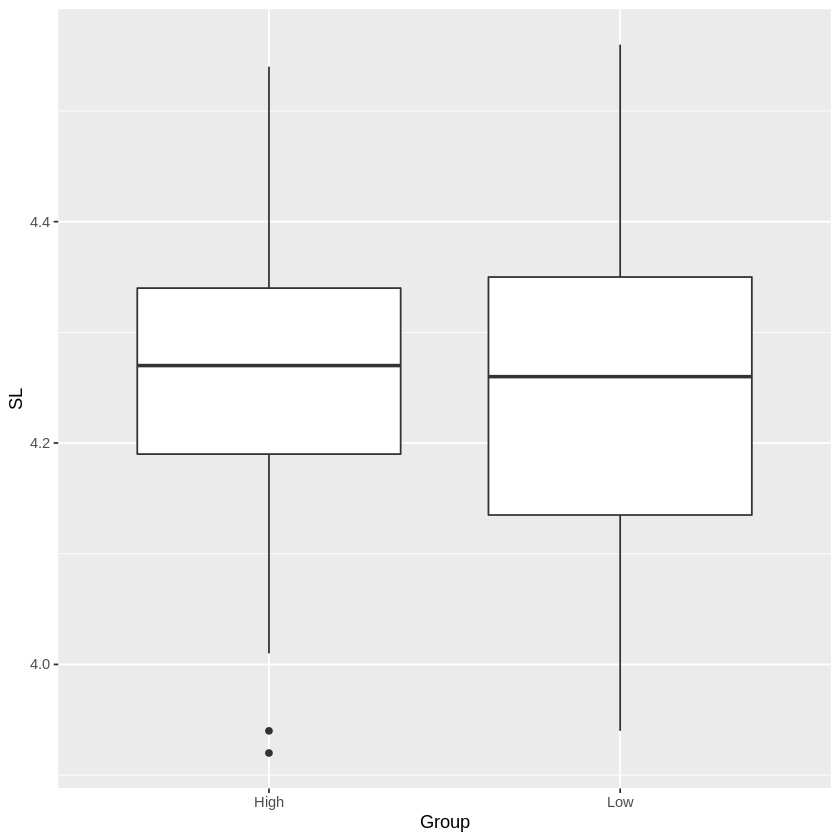

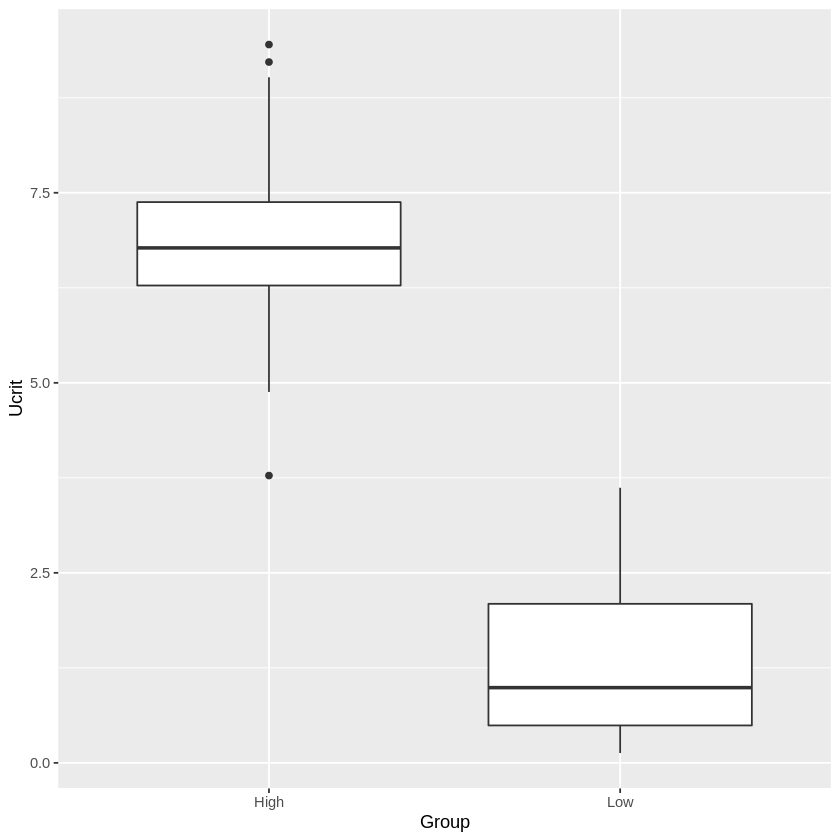

In [36]:
ggplot()+
    geom_boxplot(data=FullMeta, aes(x=Group, y=SL))
ggplot()+
    geom_boxplot(data=FullMeta, aes(x=Group, y=Ucrit))


	Shapiro-Wilk normality test

data:  FullMeta$Ucrit
W = 0.87378, p-value = 2.217e-10


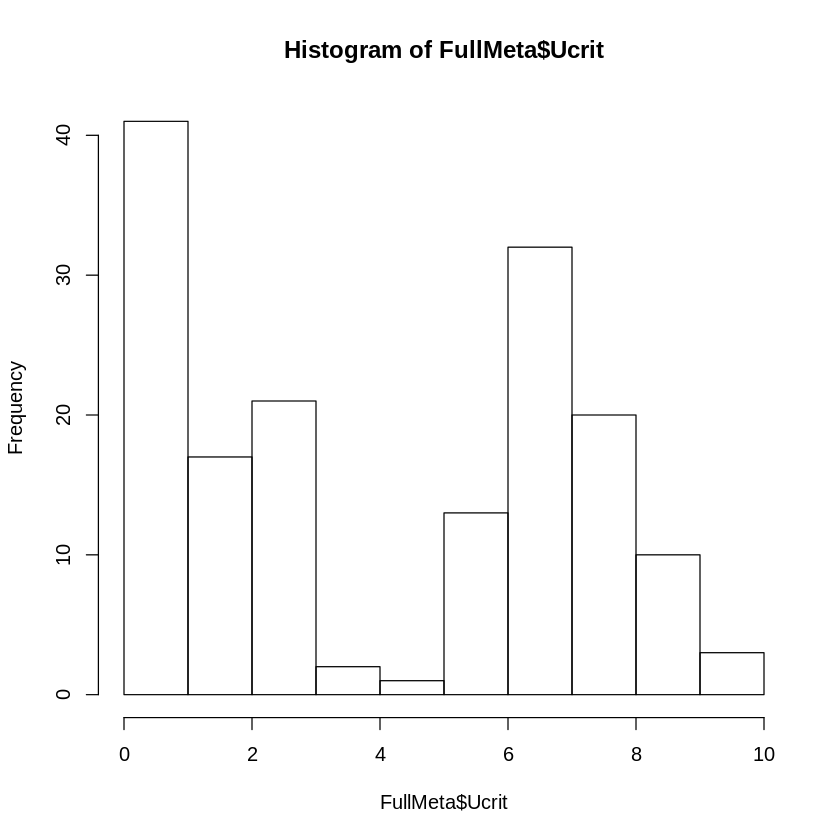

In [41]:
hist(FullMeta$Ucrit)
shapiro.test(FullMeta$Ucrit)

#hist(FullMeta$SL)

In [45]:
#transform ucrit
FullMeta[, trans := (abs(Ucrit)-mean(Ucrit))]

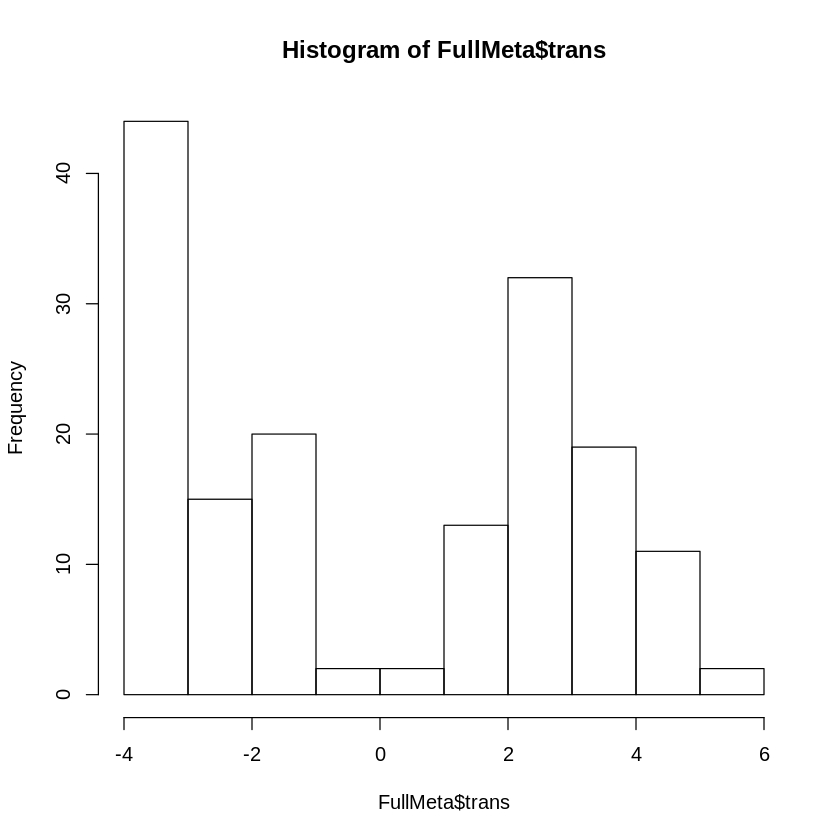

In [46]:
hist(FullMeta$trans)

In [135]:
#for plink
#the two columns we need to fill are Family ID (column 1) and the phenotype, which will be Ucrit (quant), group (case/control), or SL (quant)
#for this, we will make FamilyID the mother's ID
#FamID <- left_join(FullMeta[!is.na(Capture), .(dam, gen_id)], Fam[,-"V1"], by=c(gen_id="V2"))
##join the phenotype data
#WithPhenotypeSL <- left_join(FamID[, -"V6"], FullMeta[,.(gen_id, SL)], by="gen_id")[
#    is.na(SL), SL := -9]
#fwrite(rbind(WithPhenotypeSL, Fam[V2 %!in% WithPhenotypeSL[, gen_id]], use.names=F), "~/ClownfishGWAS/data/APPC_sequencing/DNA/filtering/imputation/plink_gwas/max_missing90_minQ20_maf01_hwe.fam", col.names = FALSE, sep = "\t")

In [20]:
#forangsd
bamlist <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt", header=TRUE)

In [21]:
head(FullMeta)
head(bamlist)

og_larvalID,larvalID,Ucrit,SL,dam,sire,tank,date,Send.to.NJ,Group,Capture,gen_id
5.06,APPC0506,8.17,4.34,D119,S162,C2:4,5/28/19,1,High,Pop13,Pop13_APPC0506
5.08,APPC0508,1.10,NA,D119,S162,C2:4,5/28/19,1,Low,Pop13,Pop13_APPC0508
5.15,APPC0515,2.27,4.32,D119,S162,C2:4,5/28/19,1,Low,Pop13,Pop13_APPC0515
5.23,APPC0523,8.33,4.32,D119,S162,C2:4,5/28/19,1,High,Pop13,Pop13_APPC0523
6.01,APPC0601,2.57,4.24,D32,S101,D1:3,5/29/19,1,Low,Pop13,Pop13_APPC0601
6.07,APPC0607,2.38,3.94,D32,S101,D1:3,5/29/19,1,Low,Pop13,Pop13_APPC0607


sample
Pop01_APPC1611
Pop01_APPC1917
Pop01_APPC1921
Pop01_APPC2029
Pop01_APPC2030
Pop01_APPC2101


In [22]:
ForAngsd <- right_join(FullMeta, bamlist, by=c(gen_id="sample"))[order(gen_id)][is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0]#[, "Group"]

Warning message in `[.data.table`(right_join(FullMeta, bamlist, by = c(gen_id = "sample"))[order(gen_id)][is.na(Group), :
“Coerced double RHS to character to match the type of the target column (column 10 named 'Group'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `Group`:=as.double(`Group`)]. If the RHS of := has nrow(DT) elements then the assignment is called a column plonk and is the way

In [23]:
(ForAngsd[is.na(Ucrit)])
#fwrite(ForAngsd, "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")

og_larvalID,larvalID,Ucrit,SL,dam,sire,tank,date,Send.to.NJ,Group,Capture,gen_id


In [24]:
#ForAngsd

In [108]:
#fwrite(ForAngsd[,.(Group)], "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_pheno.ybin")
#once I get the phenos from E
#fwrite(ForAngsd[,.(SL)], "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_pheno.ybin")
#fwrite(ForAngsd[,.(Ucrit)], "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Ucrit_pheno.ybin")

In [167]:
#fwrite(ForAngsd[,.(Ucrit)], "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Ucrit_pheno.ybin")


In [25]:
head(ForAngsd)
pca <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/output.pcangsd.cov") 
head(pca)
qc_format <- cbind(ForAngsd[, .(gen_id, Group, Ucrit, SL, Capture, dam, sire, tank)], pca[, 1:10])

og_larvalID,larvalID,Ucrit,SL,dam,sire,tank,date,Send.to.NJ,Group,Capture,gen_id
16.11,APPC1611,8.13,4.40,D125,S144,C1:4,6/19/19,1,1,Pop01,Pop01_APPC1611
19.17,APPC1917,1.20,4.35,D85,S173,C2:2,6/27/19,1,0,Pop01,Pop01_APPC1917
19.21,APPC1921,7.33,4.28,D85,S173,C2:2,6/27/19,1,1,Pop01,Pop01_APPC1921
20.29,APPC2029,8.82,4.25,D70,S98,A3:1,6/28/19,1,1,Pop01,Pop01_APPC2029
20.30,APPC2030,7.32,4.54,D70,S98,A3:1,6/28/19,1,1,Pop01,Pop01_APPC2030
21.01,APPC2101,5.07,3.94,D269,S94,D1:2,7/1/19,1,1,Pop01,Pop01_APPC2101


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159
1.3353486,0.3883862,-0.0135418,0.1148110,-0.0834899,-0.2781414,0.4290567,-0.1877678,0.3704657,-0.2801444,...,-0.3076701,-0.1148423,-0.2858137,0.2896614,0.3269241,-0.2589612,-0.2517436,-0.2458638,-0.2341706,-0.1857256
0.3883862,1.4457219,-0.0164109,0.1396048,-0.1011803,-0.3369562,0.5191065,-0.2275145,0.4480954,-0.3393794,...,-0.3725389,-0.1391699,-0.3459328,0.3509004,0.3958668,-0.3137049,-0.3050379,-0.2979042,-0.2837050,-0.2250776
-0.0135418,-0.0164109,0.9989417,-0.0048510,0.0035284,0.0117386,-0.0181368,0.0079301,-0.0156596,0.0118300,...,0.0129804,0.0048506,0.0120677,-0.0122319,-0.0138073,0.0109271,0.0106282,0.0103792,0.0098764,0.0078427
0.1148110,0.1396048,-0.0048510,1.0802584,-0.0298901,-0.0999669,0.1530357,-0.0673211,0.1322171,-0.1005468,...,-0.1109381,-0.0411579,-0.1031910,0.1037075,0.1169366,-0.0932053,-0.0903311,-0.0882320,-0.0839847,-0.0666183
-0.0834899,-0.1011803,0.0035284,-0.0298901,0.9720282,0.0723817,-0.1118132,0.0488852,-0.0965492,0.0729405,...,0.0800525,0.0298987,0.0743544,-0.0754242,-0.0851352,0.0673722,0.0655393,0.0639933,0.0609266,0.0483445
-0.2781414,-0.3369562,0.0117386,-0.0999669,0.0723817,0.9689472,-0.3721078,0.1627734,-0.3213479,0.2429079,...,0.2651766,0.0995643,0.2453448,-0.2512747,-0.2835847,0.2232014,0.2179205,0.2129748,0.2023685,0.1609690


In [30]:
fwrite(qc_format[,.(dam, sire)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/parent_id.cov")


In [26]:

#fwrite(qc_format, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/qc.sample", quote = F, sep=" ", na="NA")


In [51]:
ForAngsd <- right_join(WithPhenotypeHighLow, bamlist, by=c(gen_id="sample"))[order(gen_id)][]#[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, "Group"]

In [60]:
ForAngsdSLQuant <- right_join(left_join(FamID[, -"V6"], FullMeta[,.(gen_id, SL)], by="gen_id"), bamlist, by=c(gen_id="sample"))[order(gen_id)][is.na(SL), SL :=-999][, "SL"]#[Group=="High", Group:=1][Group=="Low", Group:=0][, "Group"]

In [1]:
head(ForAngsd)

ERROR: Error in head(ForAngsd): object 'ForAngsd' not found


In [63]:
head(ForAngsdSLQuant)
fwrite(ForAngsdSLQuant, "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_pheno.ybin")

SL
4.40
4.35
4.28
4.25
4.54
3.94


In [144]:
#for null distribution of pvalues
set.seed(77)
shuffle <- ForAngsd[sample(.N,nrow(ForAngsd), replace = TRUE)]

In [145]:
head(shuffle)

og_larvalID,larvalID,Ucrit,SL,dam,sire,tank,date,Send.to.NJ,Group,Capture,gen_id
22.12,APPC2212,6.70,4.30,D19,S175,A1:4,7/2/19,1,1,Pop15,Pop15_APPC2212
23.04,APPC2304,0.13,4.37,D74,S116,C1:3,7/3/19,1,0,Pop06,Pop06_APPC2304
15.17,APPC1517,0.88,4.36,D10,S156,B2:5,6/17/19,1,0,Pop04,Pop04_APPC1517
13.18,APPC1318,0.30,4.23,D22,S103,B3:1,6/12/19,1,0,Pop03,Pop03_APPC1318
24.14,APPC2414,1.03,4.30,D58,S296,D3:3,7/11/19,1,0,Pop07,Pop07_APPC2414
32.24,APPC3224,0.72,4.52,D5,S137,A1:5,7/29/19,1,0,Pop09,Pop09_APPC3224


In [146]:
fwrite(shuffle[,.(Group)], "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_pheno_NULL.ybin")

In [64]:
ForAngsdUcritQuant <- right_join(left_join(FamID[, -"V6"], FullMeta[,.(gen_id, Ucrit)], by="gen_id"), bamlist, by=c(gen_id="sample"))[order(gen_id)][is.na(Ucrit), Ucrit :=-999][, "Ucrit"]#[Group=="High", Group:=1][Group=="Low", Group:=0][, "Group"]

In [66]:
head(ForAngsdUcritQuant)
fwrite(ForAngsdUcritQuant, "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Ucrit_pheno.ybin")

Ucrit
8.13
1.20
7.33
8.82
7.32
5.07
